In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
import lsst.daf.butler as dafButler
from lsst.pex.config import Config
from lsst.pipe.base import Instrument

In [3]:
import lsst.afw.display as afwDisplay
import lsst.display.astrowidgets
afwDisplay.setDefaultBackend('astrowidgets')
import gc

In [52]:
import random

In [4]:
afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')
%matplotlib inline

In [5]:
params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [8, 8],
          'figure.facecolor': 'White'
          }
plt.rcParams.update(params)

In [6]:
repo = '/sdf/group/rubin/repo/embargo'
skymapName = 'latiss_v1'
instrumentName = 'LATISS'

collection_good = f"u/{os.environ['USER']}/auxtel_deepCoadd_goodseeing_subtract"
collection_deep = f"u/{os.environ['USER']}/auxtel_deepCoadd_template_subtract"

butler_good = dafButler.Butler(repo, collections=collection_good, skymap=skymapName)
butler_deep = dafButler.Butler(repo, collections=collection_deep, skymap=skymapName)

registry_good = butler_good.registry
registry_deep = butler_deep.registry

In [7]:
def multiVisitPlotter(butler, visitList, detectorList, datasetType='goodSeeingDiff_diaSrc', badFlagList=None, printBadDiaSourceInfo=False):
    """Plot DiaSources from multiple visits.
    """
    for (visit, detector) in zip(visitList, detectorList):
        try:
            oneDiaSourceTable = butler.get(datasetType, visit=visit, detector = detector)
        except LookupError:
            print(f'There is no visit {visit}, skipping it')
            continue
        else:
            # Deal with schema changes
            if 'filterName' in oneDiaSourceTable.columns:
                filterColumnName = 'filterName'
            else:
                filterColumnName = 'band'
            if 'decl' in oneDiaSourceTable.columns:
                decColumnName = 'decl'
            else:
                decColumnName = 'dec'
            
            if oneDiaSourceTable[filterColumnName][0] == 'g':
                color = 'C0'  # blue
            elif oneDiaSourceTable[filterColumnName][0] == 'r':
                color = 'C1'  # orange
            elif oneDiaSourceTable[filterColumnName][0] == 'i':
                color = 'C3'  # red
            else:
                color = '0.75'  # gray
            if badFlagList is None:  # ADDED LATER
                plt.scatter(oneDiaSourceTable.ra, oneDiaSourceTable[decColumnName], s=5, color=color)
                if printBadDiaSourceInfo:
                    print('Not filtering out any DiaSources; no badDiaSourceInfo to print')
            else:
                # Build up all the bad flags, e.g., (df['badflag1'] | df['badflag2'])
                conditionList = [oneDiaSourceTable[badFlag]==False for badFlag in badFlagList]
                bitwise_or_bad_flags = conditionList[0]
                for condition in conditionList:
                    bitwise_or_bad_flags |= condition
                bitwise_or_bad_flags.name = 'bitwise_or_bad_flags'
                if printBadDiaSourceInfo:
                    print(f'Visit {visit}: Ignoring {bitwise_or_bad_flags.value_counts().values[1]} bad DiaSources ({bitwise_or_bad_flags.value_counts().values[0]} DiaSources remain)')
                plt.scatter(oneDiaSourceTable.loc[bitwise_or_bad_flags, 'ra'],
                            oneDiaSourceTable.loc[bitwise_or_bad_flags, decColumnName],
                            s=5, color=color)
            plt.xlabel('RA (deg)')
            plt.ylabel('Dec (deg)')

In [8]:
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)

    return cutout_image

def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure

In [164]:
diff_dataId = {'instrument': 'LATISS', 'detector': 0, 'visit': 2023070400470, 
 'band': 'g', 'physical_filter': 'SDSSg_65mm~empty'}
diff_datasetType = 'goodSeeingDiff_differenceExp'

diff_image_good = butler_good.get(diff_datasetType, **diff_dataId).image
# diff_image_deep = butler_deep.get(diff_datasetType, **diff_dataId).image

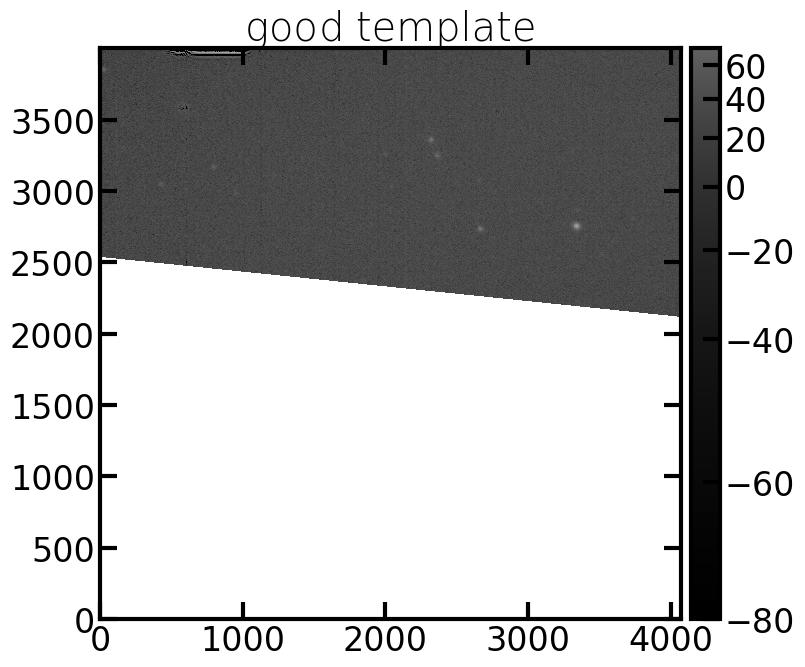

In [165]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(diff_image_good)
plt.title('good template')
plt.show()
remove_figure(fig)

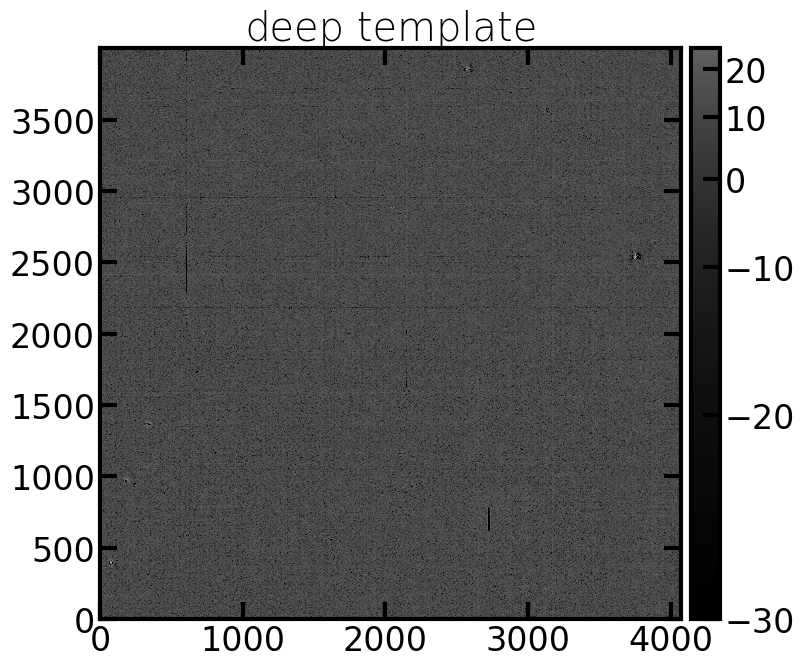

In [11]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(diff_image_deep)
plt.title('deep template')
plt.show()
remove_figure(fig)

In [16]:
# for dt in sorted(registry_good.queryDatasetTypes()):
#     print(dt)

In [13]:
print(registry_deep.queryDatasets('deepDiff_diaSrcTable').count())
print(registry_deep.queryDatasets('deepDiff_diaSourceTable').count())
print(registry_deep.queryDatasets('deepDiff_diaSrc_schema').count())

print(registry_deep.queryDatasets('goodSeeingDiff_diaObjTable').count())
print(registry_deep.queryDatasets('goodSeeingDiff_diaSrc').count())
print(registry_deep.queryDatasets('deepDiff_diaSourceTable').count())
print(registry_deep.queryDatasets('deepDiff_diaSrc_schema').count())

print(registry_deep.queryDatasets('diaSourceTable').count()) # what Meredith's notebook is looking at

0
0
0
0
1913
0
0
0


In [153]:
print(registry_deep.queryDatasets('goodSeeingDiff_diaSrcTable').count())
print(registry_good.queryDatasets('goodSeeingDiff_diaSrcTable').count())

1913
1920


In [15]:
print(registry_good.queryDatasets('deepDiff_diaSrcTable').count())
print(registry_good.queryDatasets('deepDiff_diaSourceTable').count())
print(registry_good.queryDatasets('deepDiff_diaSrc_schema').count())

print(registry_good.queryDatasets('goodSeeingDiff_diaObjTable').count())
print(registry_good.queryDatasets('goodSeeingDiff_diaSrc').count())
print(registry_good.queryDatasets('deepDiff_diaSourceTable').count())
print(registry_good.queryDatasets('deepDiff_diaSrc_schema').count())

print(registry_good.queryDatasets('diaSourceTable').count())

0
0
0
0
1920
0
0
0


In [15]:
print(registry_deep.queryDatasets('goodSeeingDiff_diaSrc').count())
print(registry_good.queryDatasets('goodSeeingDiff_diaSrc').count())

1913
1920


In [16]:
print(registry_good.queryDatasets('goodSeeingCoadd').count())
print(registry_deep.queryDatasets('goodSeeingCoadd').count())

290
290


In [17]:
print(registry_good.queryDatasets('goodSeeingDiff_assocDiaSrcTable').count())
print(registry_deep.queryDatasets('goodSeeingDiff_assocDiaSrcTable').count())

0
0


In [17]:
visitList_deep = []
for item in registry_deep.queryDatasets('goodSeeingDiff_diaSrcTable'):
    visitList_deep.append(item.dataId.get('visit'))

visitList_good = []
for item in registry_good.queryDatasets('goodSeeingDiff_diaSrcTable'):
    visitList_good.append(item.dataId.get('visit'))

In [19]:
detector_deep = []
for item in registry_deep.queryDatasets('goodSeeingDiff_diaSrcTable'):
    detector_deep.append(item.dataId.get('detector'))

detector_good = []
for item in registry_good.queryDatasets('goodSeeingDiff_diaSrcTable'):
    detector_good.append(item.dataId.get('detector'))

In [20]:
print(visitList_deep[0:5])
print(visitList_good[0:5])

[2023080300489, 2023070400572, 2023070600473, 2023070600351, 2023070400556]
[2023070500345, 2023092800131, 2023082900426, 2023070600323, 2023080300586]


In [21]:
print(len(set(visitList_deep)))
print(len(set(visitList_good)))

1913
1920


In [155]:
new_list = []
for item in registry_deep.queryDatasets('subtractImages_log'):
    new_list.append(item.dataId.get('visit'))

In [156]:
new_list_good = []
for item in registry_good.queryDatasets('subtractImages_log'):
    new_list_good.append(item.dataId.get('visit'))

In [72]:
len(set(new_list))

1943

In [74]:
len(set(new_list_good))

1943

In [49]:
# look at common visits in both the collections:
common_visits = set(visitList_deep) & set(visitList_good)

In [160]:
unique_visits = set(visitList_good) - set(visitList_deep)

In [161]:
unique_visits

{2023070400470,
 2023070400512,
 2023070400516,
 2023070400518,
 2023070400601,
 2023110700467,
 2023110700468}

In [163]:
refs_unique = registry_deep.queryDatasets('goodSeeingCoadd', visit=2023070400470)
for ref in refs_unique:
    print(ref.dataId.mapping)

{band: 'g', skymap: 'latiss_v1', tract: 5616, patch: 336}
{band: 'g', skymap: 'latiss_v1', tract: 5616, patch: 337}


In [70]:
random_visit_list = []
for i, val in enumerate(random.sample(sorted(common_visits), 16)):
    print(i, val)
    random_visit_list.append(val)

0 2023081600316
1 2023070400462
2 2023080200642
3 2023080300456
4 2023051100351
5 2023070400591
6 2023092800130
7 2023070600487
8 2023051100284
9 2023082900443
10 2023092800094
11 2023072000343
12 2023052400660
13 2023052300643
14 2023082900495
15 2023071800235


In [33]:
print(len(common_visits))

1913


All of deep visits are in good visits

In [35]:
# refs_deep = registry_deep.queryDatasets('goodSeeingCoadd', visit=2023070500393)
# refs_good = registry_good.queryDatasets('goodSeeingCoadd', visit=2023070500393)

In [36]:
# for ref in refs_good:
#     print(ref.dataId.mapping)

{band: 'r', skymap: 'latiss_v1', tract: 5634, patch: 72}
{band: 'r', skymap: 'latiss_v1', tract: 5634, patch: 73}
{band: 'r', skymap: 'latiss_v1', tract: 5634, patch: 74}
{band: 'r', skymap: 'latiss_v1', tract: 5634, patch: 91}
{band: 'r', skymap: 'latiss_v1', tract: 5634, patch: 92}
{band: 'r', skymap: 'latiss_v1', tract: 5634, patch: 93}


In [37]:
# for ref in refs_deep:
#     print(ref.dataId.mapping)

{band: 'r', skymap: 'latiss_v1', tract: 5634, patch: 72}
{band: 'r', skymap: 'latiss_v1', tract: 5634, patch: 73}
{band: 'r', skymap: 'latiss_v1', tract: 5634, patch: 74}
{band: 'r', skymap: 'latiss_v1', tract: 5634, patch: 91}
{band: 'r', skymap: 'latiss_v1', tract: 5634, patch: 92}
{band: 'r', skymap: 'latiss_v1', tract: 5634, patch: 93}


In [24]:
refs_good = registry_good.queryDatasets('goodSeeingDiff_diaSrcTable', visit=2023070500393)
refs_deep = registry_deep.queryDatasets('goodSeeingDiff_diaSrcTable', visit=2023070500393)

In [25]:
for ref in refs_good:
    print(ref.dataId.mapping)

{instrument: 'LATISS', detector: 0, visit: 2023070500393, band: 'r', physical_filter: 'SDSSr_65mm~empty'}


In [26]:
for ref in refs_deep:
    print(ref.dataId.mapping)

{instrument: 'LATISS', detector: 0, visit: 2023070500393, band: 'r', physical_filter: 'SDSSr_65mm~empty'}


In [27]:
oneDiaSourceTable_good = butler_good.get('goodSeeingDiff_diaSrcTable', visit=2023070500393, detector=0)
oneDiaSourceTable_deep = butler_deep.get('goodSeeingDiff_diaSrcTable', visit=2023070500393, detector=0)

In [29]:
# oneDiaSourceTable_deep

In [30]:
oneDiaSourceTable_deep.columns

Index(['diaSourceId', 'ccdVisitId', 'band', 'diaObjectId', 'ssObjectId',
       'parentDiaSourceId', 'midpointMjdTai', 'bboxSize', 'time_processed',
       'ra', 'dec', 'raErr', 'decErr', 'ra_dec_Cov', 'x', 'y', 'xErr', 'yErr',
       'apFlux', 'apFluxErr', 'snr', 'psfFlux', 'psfFluxErr', 'psfChi2',
       'psfNdata', 'trailFlux', 'trailRa', 'trailDec', 'trailLength',
       'trailAngle', 'dipoleMeanFlux', 'dipoleMeanFluxErr', 'dipoleFluxDiff',
       'dipoleFluxDiffErr', 'dipoleLength', 'dipoleAngle', 'dipoleChi2',
       'isDipole', 'dipoleNdata', 'scienceFlux', 'scienceFluxErr', 'ixx',
       'iyy', 'ixy', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'reliability', 'pixelFlags',
       'pixelFlags_offimage', 'pixelFlags_edge', 'pixelFlags_interpolated',
       'pixelFlags_saturated', 'pixelFlags_cr', 'pixelFlags_bad',
       'pixelFlags_suspect', 'pixelFlags_interpolatedCenter',
       'pixelFlags_saturatedCenter', 'pixelFlags_crCenter',
       'pixelFlags_suspectCenter', 'centroid_flag', 'centroi

In [31]:
oneDiaSourceTable_deep['dec']

0    -25.050428
1    -25.050969
2    -25.050064
3    -25.047295
4    -25.048070
        ...    
90   -24.953155
91   -24.954057
92   -24.954117
93   -24.949909
94   -24.947987
Name: dec, Length: 95, dtype: float64

Schema doesn't have band information?

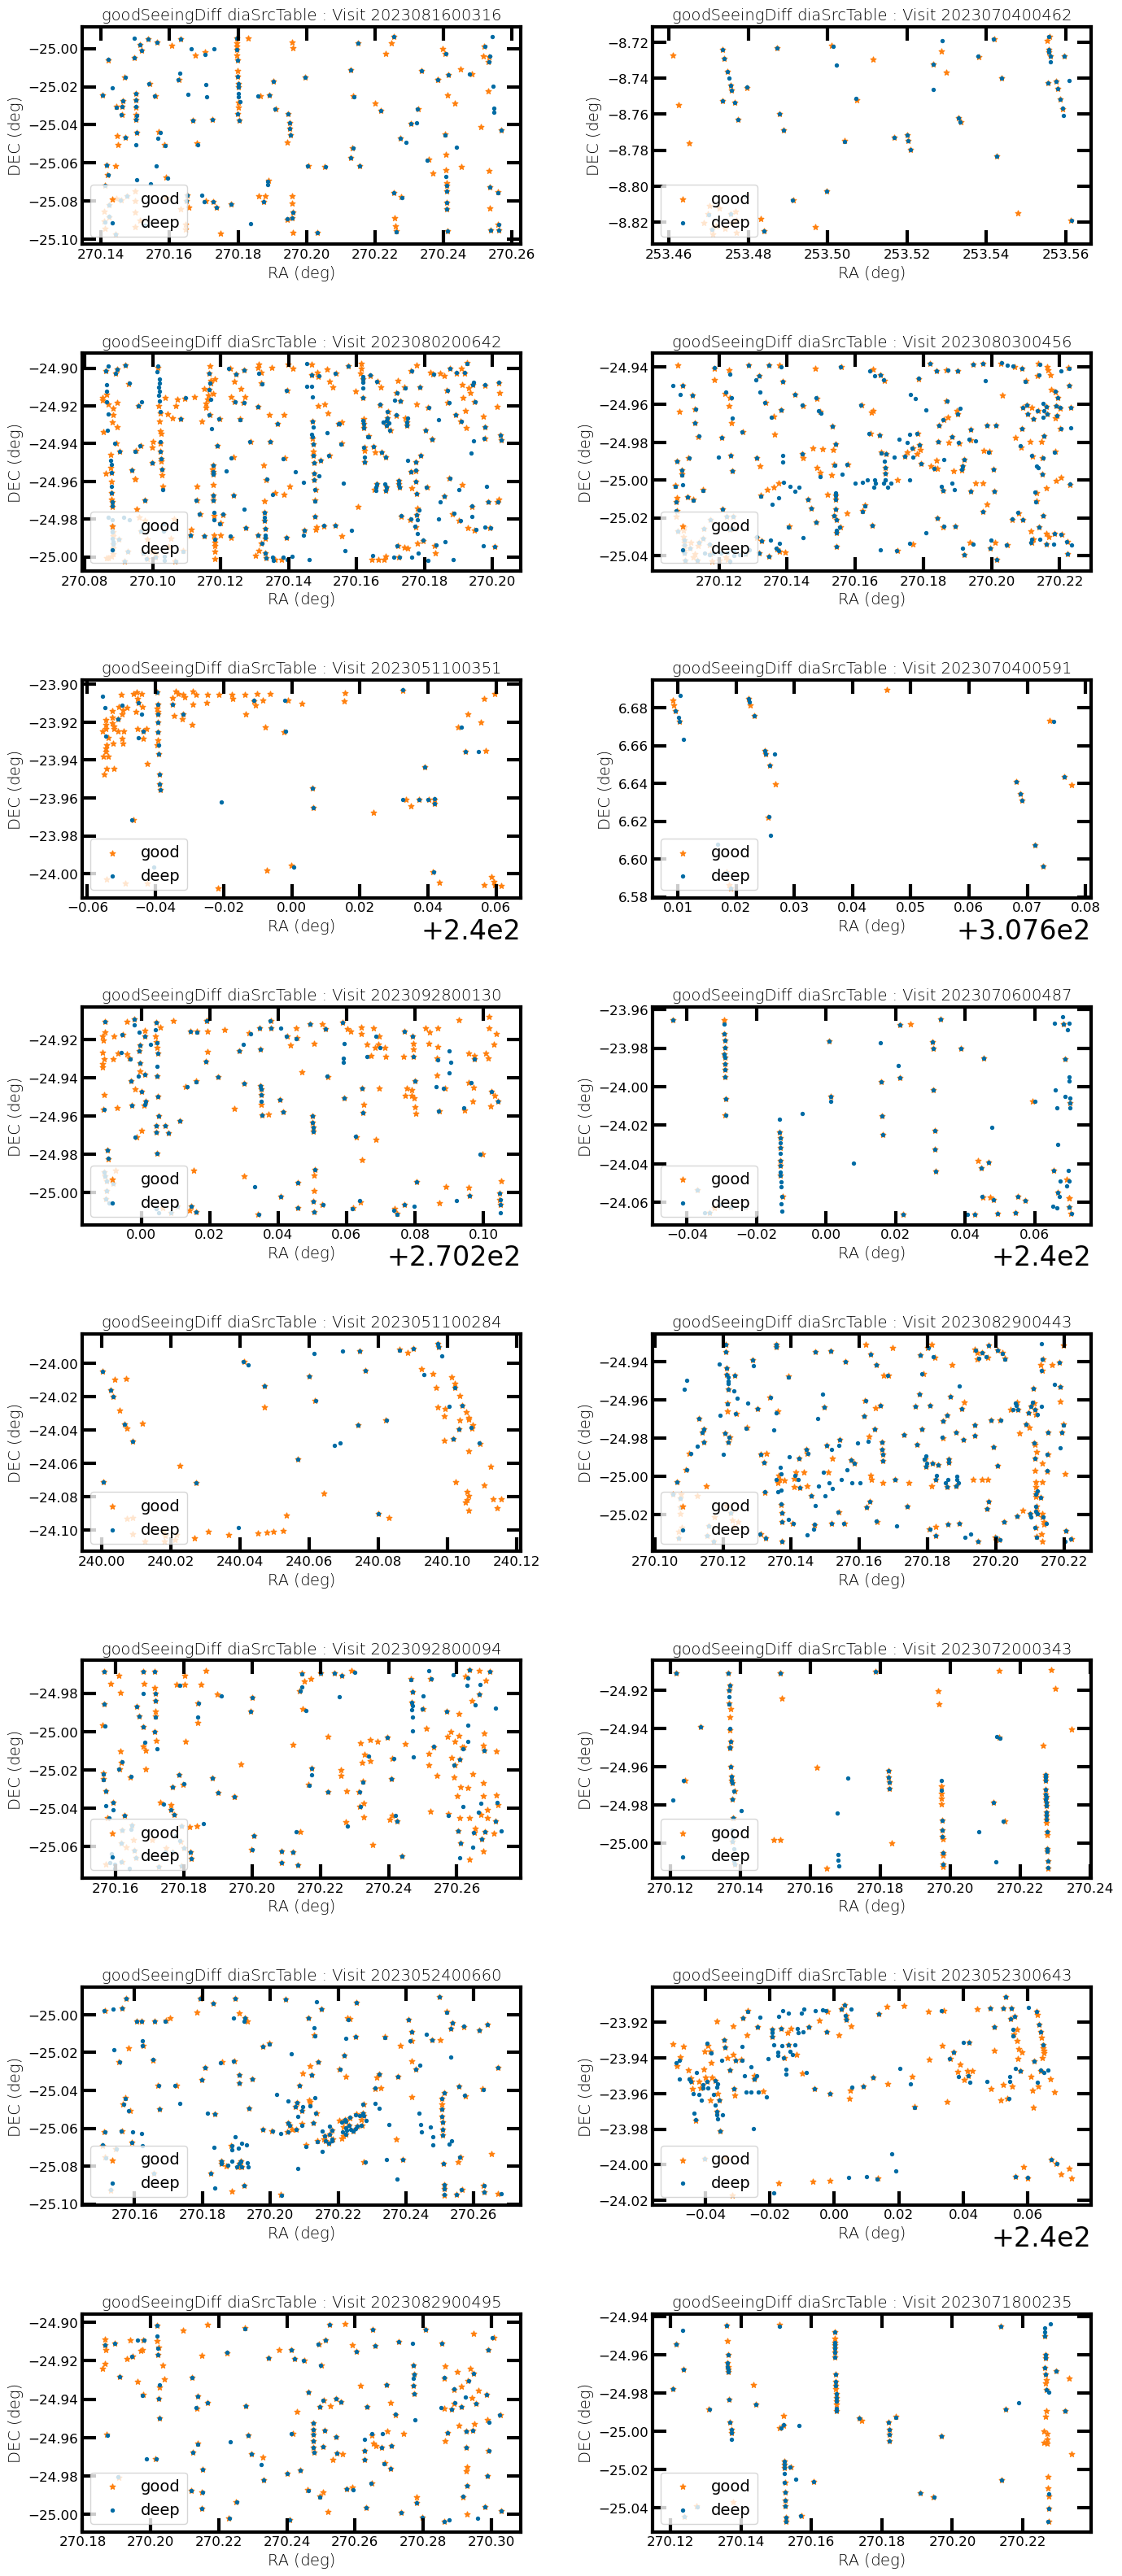

In [76]:
fig, axs = plt.subplots(int(len(random_visit_list)/2),2, figsize=(16, 40), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)

axs = axs.ravel()
for i, visit in enumerate(random_visit_list):
    oneDiaSourceTable_good = butler_good.get('goodSeeingDiff_diaSrcTable', visit=visit, detector=0)
    oneDiaSourceTable_deep = butler_deep.get('goodSeeingDiff_diaSrcTable', visit=visit, detector=0)
    
    axs[i].scatter(oneDiaSourceTable_good['ra'], oneDiaSourceTable_good['dec'], s=24, color='C1', label='good', marker='*')
    axs[i].scatter(oneDiaSourceTable_deep['ra'], oneDiaSourceTable_deep['dec'], s=8, color='C0', label = 'deep')
    axs[i].set_title('goodSeeingDiff diaSrcTable : Visit '+ str(visit), fontsize=14)
    axs[i].set_xlabel('RA (deg)', fontsize=14)
    axs[i].set_ylabel('DEC (deg)', fontsize=14)
    axs[i].xaxis.set_tick_params(labelsize=12)
    axs[i].yaxis.set_tick_params(labelsize=12)
    # axs[i].set_xticks(fontsize=12)
    # axs[i].set_yticks(fontsize=12)
    axs[i].legend(loc='lower left')

### SNR histograms

In [108]:
flux_df_good = oneDiaSourceTable_good[['scienceFlux', 'scienceFluxErr']]
flux_df_good = flux_df_good[flux_df_good['scienceFlux'] > 0]
flux_df_deep = oneDiaSourceTable_deep[['scienceFlux', 'scienceFluxErr']]
flux_df_deep = flux_df_deep[flux_df_deep['scienceFlux'] > 0]

In [121]:
flux_df_good['SNR'] = flux_df_good['scienceFlux']/flux_df_good['scienceFluxErr']
flux_df_deep['SNR'] = flux_df_deep['scienceFlux']/flux_df_deep['scienceFluxErr']

In [124]:
print(min(flux_df_good['SNR']), max(flux_df_good['SNR']))

0.9324529328175605 275.7619477631622


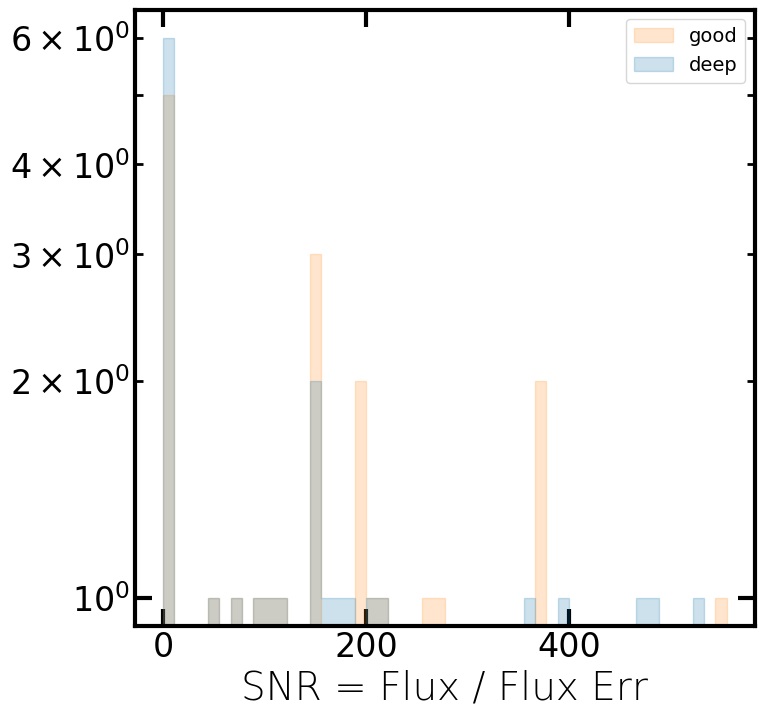

In [144]:
counts, bins = np.histogram(flux_df_good['SNR'], bins=50)

plt.yscale('log');

plt.hist(flux_df_good['SNR'],bins=bins, histtype = 'step', label='good', alpha=0.2, edgecolor='C1', color='C1', fill=True);
plt.hist(flux_df_deep['SNR'],bins=bins, histtype = 'step', label='deep', alpha=0.2, edgecolor='C0', color='C0', fill=True);

plt.xlabel('SNR = Flux / Flux Err')
plt.legend(loc='upper right')

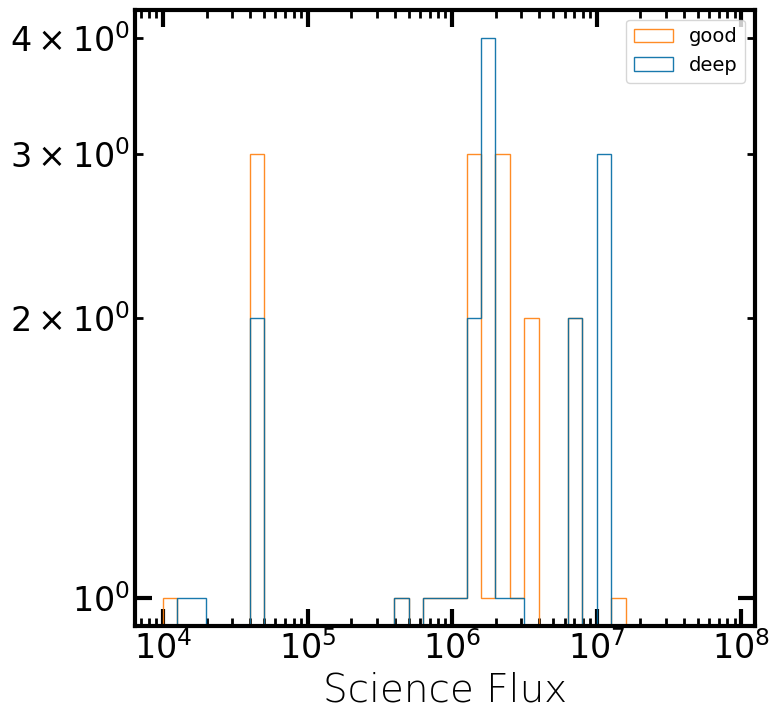

In [148]:
bins = 10**(np.arange(4,8,0.1));
plt.xscale('log');
plt.yscale('log');

plt.hist(flux_df_good['scienceFlux'],bins=bins, histtype = 'step', label='good', alpha=0.9, edgecolor='C1', fill=False);
plt.hist(flux_df_deep['scienceFlux'],bins=bins, histtype = 'step', label='deep', alpha=0.9, edgecolor='C0', fill=False);

plt.xlabel('Science Flux')
plt.legend(loc='upper right')

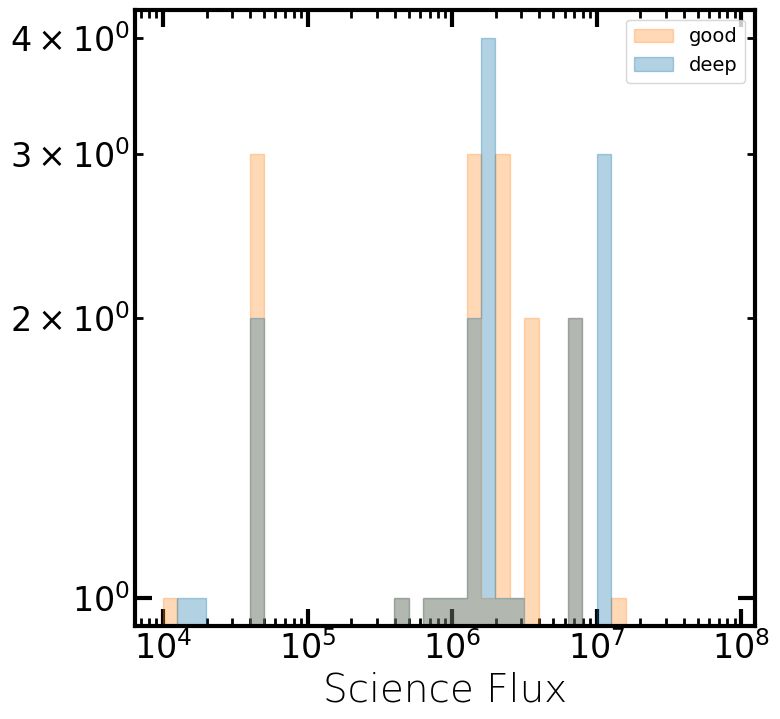

In [149]:
bins = 10**(np.arange(4,8,0.1));
plt.xscale('log');
plt.yscale('log');

plt.hist(flux_df_good['scienceFlux'],bins=bins, histtype = 'step', label='good', alpha=0.3, edgecolor='C1', color='C1', fill=True);
plt.hist(flux_df_deep['scienceFlux'],bins=bins, histtype = 'step', label='deep', alpha=0.3, edgecolor='C0', color='C0', fill=True);

plt.xlabel('Science Flux')
plt.legend(loc='upper right')

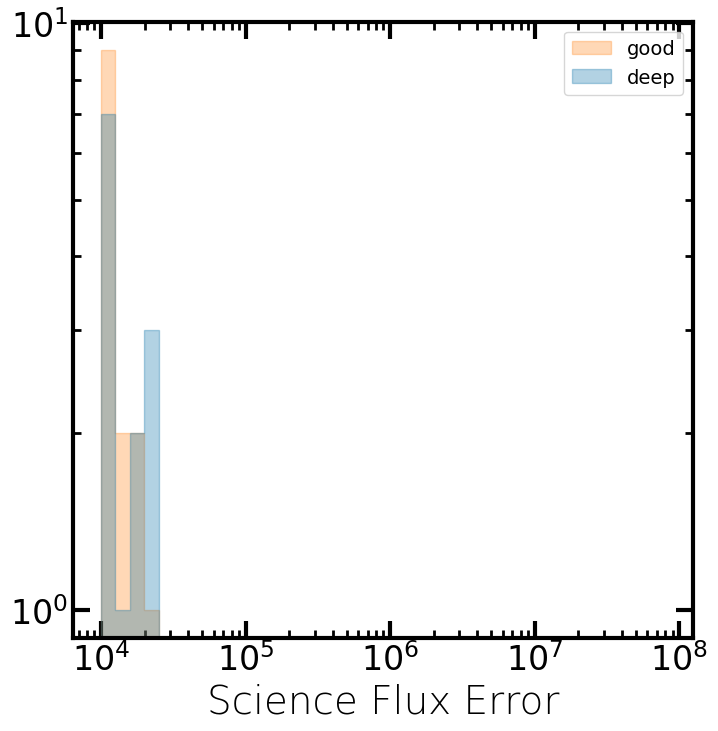

In [145]:
bins = 10**(np.arange(4,8,0.1));
plt.xscale('log');
plt.yscale('log');

plt.hist(flux_df_good['scienceFluxErr'],bins=bins, histtype = 'step', label='good', alpha=0.3, edgecolor='C1', color='C1', fill=True);
plt.hist(flux_df_deep['scienceFluxErr'],bins=bins, histtype = 'step', label='deep', alpha=0.3, edgecolor='C0', color='C0', fill=True);

plt.xlabel('Science Flux Error')

plt.legend(loc='upper right')

## Plotting scatter plot and histograms together

In [152]:
for i, visit in enumerate(random_visit_list):
    print('Plotting visit', visit)
    oneDiaSourceTable_good = butler_good.get('goodSeeingDiff_diaSrcTable', visit=visit, detector=0)
    oneDiaSourceTable_deep = butler_deep.get('goodSeeingDiff_diaSrcTable', visit=visit, detector=0)

    flux_df_good = oneDiaSourceTable_good[['scienceFlux', 'scienceFluxErr']]
    flux_df_good = flux_df_good[flux_df_good['scienceFlux'] > 0]
    flux_df_deep = oneDiaSourceTable_deep[['scienceFlux', 'scienceFluxErr']]
    flux_df_deep = flux_df_deep[flux_df_deep['scienceFlux'] > 0]
    flux_df_good['SNR'] = flux_df_good['scienceFlux']/flux_df_good['scienceFluxErr']
    flux_df_deep['SNR'] = flux_df_deep['scienceFlux']/flux_df_deep['scienceFluxErr']

    fig, axs = plt.subplots(2,2, figsize=(15,15), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.3)
    axs = axs.ravel()

    # scatter plot
    axs[0].scatter(oneDiaSourceTable_good['ra'], oneDiaSourceTable_good['dec'], s=32, color='C1', label='good', marker='*')
    axs[0].scatter(oneDiaSourceTable_deep['ra'], oneDiaSourceTable_deep['dec'], s=10, color='C0', label = 'deep')
    axs[0].set_title('goodSeeingDiff diaSrcTable : Visit '+ str(visit), fontsize=14)
    axs[0].set_xlabel('RA (deg)', fontsize=14)
    axs[0].set_ylabel('DEC (deg)', fontsize=14)
    axs[0].xaxis.set_tick_params(labelsize=12)
    axs[0].yaxis.set_tick_params(labelsize=12)
    axs[0].legend(loc='lower left')

    # SNR plot
    counts_snr, bins_snr = np.histogram(flux_df_good['SNR'], bins=50)
    axs[1].set_yscale('log');
    axs[1].hist(flux_df_good['SNR'],bins=bins_snr, histtype = 'step', label='good', alpha=0.3, edgecolor='C1', color='C1', fill=True);
    axs[1].hist(flux_df_deep['SNR'],bins=bins_snr, histtype = 'step', label='deep', alpha=0.3, edgecolor='C0', color='C0', fill=True);
    axs[1].set_xlabel('SNR = Flux / Flux Err')
    axs[1].legend(loc='upper right')

    # flux plot
    bins = 10**(np.arange(4,8,0.1));
    axs[2].set_xscale('log');
    axs[2].set_yscale('log');
    axs[2].hist(flux_df_good['scienceFlux'],bins=bins, histtype = 'step', label='good', alpha=0.3, edgecolor='C1', color='C1', fill=True);
    axs[2].hist(flux_df_deep['scienceFlux'],bins=bins, histtype = 'step', label='deep', alpha=0.3, edgecolor='C0', color='C0', fill=True);
    axs[2].set_xlabel('Science Flux')
    axs[2].legend(loc='upper right')

    # flux error plot
    bins = 10**(np.arange(4,8,0.1));
    axs[3].set_xscale('log');
    axs[3].set_yscale('log');
    axs[3].hist(flux_df_good['scienceFluxErr'],bins=bins, histtype = 'step', label='good', alpha=0.3, edgecolor='C1', color='C1', fill=True);
    axs[3].hist(flux_df_deep['scienceFluxErr'],bins=bins, histtype = 'step', label='deep', alpha=0.3, edgecolor='C0', color='C0', fill=True);
    axs[3].set_xlabel('Science Flux Error')
    axs[3].legend(loc='upper right')

    plt.savefig('good_deep_visit_'+str(visit))
    plt.close()

Plotting visit 2023081600316
Plotting visit 2023070400462
Plotting visit 2023080200642
Plotting visit 2023080300456
Plotting visit 2023051100351
Plotting visit 2023070400591
Plotting visit 2023092800130
Plotting visit 2023070600487
Plotting visit 2023051100284
Plotting visit 2023082900443
Plotting visit 2023092800094
Plotting visit 2023072000343
Plotting visit 2023052400660
Plotting visit 2023052300643
Plotting visit 2023082900495
Plotting visit 2023071800235


In [73]:
# # plotting for all visits in visitlist
# for visit in visitList_deep[::10]:
#     oneDiaSourceTable_deep = butler_deep.get('goodSeeingDiff_diaSrc', visit=visit, detector=0)
#     plt.scatter(oneDiaSourceTable_deep['coord_ra'], oneDiaSourceTable_deep['coord_dec'], s=5, color='C0')
#     plt.xlabel('RA (deg)')
#     plt.ylabel('DEC (deg)')
#     plt.title("Plotting every 10th visit in Deep")

In [74]:
# # plotting for all visits in visitlist
# for visit in visitList_good[::10]:
#     oneDiaSourceTable_good = butler_good.get('goodSeeingDiff_diaSrc', visit=visit, detector=0)
#     plt.scatter(oneDiaSourceTable_deep['coord_ra'], oneDiaSourceTable_deep['coord_dec'], s=5, color='C1')
#     plt.xlabel('RA (deg)')
#     plt.ylabel('DEC (deg)')
#     plt.title("Plotting every 10th visit in Good")

In [75]:
# fig = plt.figure(figsize=(9,7))
# fig.suptitle(f'goodSeeingDiff_diaSrc from Deep', fontsize=10)

# ax1 = fig.add_subplot(221)
# ax1.set_xlim(0.015, 0.03)
# ax1.set_ylim(-1.275, -1.265)
# for visit in visitList_deep[0:50]:
#     oneDiaSourceTable_deep = butler_deep.get('goodSeeingDiff_diaSrc', visit=visit, detector=0)
#     plt.scatter(oneDiaSourceTable_deep['coord_ra'], oneDiaSourceTable_deep['coord_dec'], s=5, color='C0')
#     plt.xlabel('RA (deg)')
#     plt.ylabel('DEC (deg)')
    
# ax2 = fig.add_subplot(222)
# ax2.set_xlim(2.09, 2.1)
# ax2.set_ylim(-0.64, -0.63)
# for visit in visitList_deep[0:50]:
#     oneDiaSourceTable_deep = butler_deep.get('goodSeeingDiff_diaSrc', visit=visit, detector=0)
#     plt.scatter(oneDiaSourceTable_deep['coord_ra'], oneDiaSourceTable_deep['coord_dec'], s=5, color='C0')
#     plt.xlabel('RA (deg)')
#     plt.ylabel('DEC (deg)')

# ax3 = fig.add_subplot(223)
# ax3.set_xlim(4.73,4.71)
# ax3.set_ylim(-0.44, -0.433)
# for visit in visitList_deep[0:50]:
#     oneDiaSourceTable_deep = butler_deep.get('goodSeeingDiff_diaSrc', visit=visit, detector=0)
#     plt.scatter(oneDiaSourceTable_deep['coord_ra'], oneDiaSourceTable_deep['coord_dec'], s=5, color='C0')
#     plt.xlabel('RA (deg)')
#     plt.ylabel('DEC (deg)')